# A miniature implementation of ViT
Train your own hackable ViT model with vanilla pytorch

## Details
* 843k parameters as written, needing 1.3GB VRAM. ~2:30 per epoch on 8-core CPU, ~0:10 on 3050ti.
* Expected to reach ~70%+ classification accuracy on CIFAR10.
* Model dimensions have been adjusted to train quickly and work with 32x32 pixel images.
* Builds the transformer from basic layers and does not use torch's transformer blocks.
* Comparable final accuracy to an implementation using torch's transformer.

## References
https://github.com/tintn/vision-transformer-from-scratch

https://arxiv.org/abs/2010.11929 

In [1]:
dataset_root = './datasets'
print('Will store datasets in', dataset_root)

import os
cpu_num = os.cpu_count() // 2
print('Dataloaders will use {} CPUs'.format(cpu_num))

Will store datasets in ./datasets
Dataloaders will use 8 CPUs


In [2]:
import random
import math

import torch
import torch.utils.data as tud
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms.v2 as tv2
import torchvision.datasets as tds
import torchvision.utils as tu

from tqdm import tqdm
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

/home/kyle/mambaforge/envs/ml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Datasets

In [3]:
# Only apply the most basic augmentations.
train_tfs = tv2.Compose([
    tv2.ToImage(),
    tv2.RandomCrop(32, 4),
    tv2.RandomHorizontalFlip(0.5),
    tv2.RandomVerticalFlip(0.25),
    tv2.ToDtype(torch.float32, scale=True),
])

# Don't apply augmentations on the validation set.
val_tfs = tv2.Compose([
    tv2.ToImage(),
    tv2.ToDtype(torch.float32, scale=True),
])

cifar_train = tds.CIFAR10(
    root=dataset_root, download=True, train=True, transform=train_tfs)
cifar_eval = tds.CIFAR10(
    root=dataset_root, download=True, train=False, transform=val_tfs)
cifar_train = tds.wrap_dataset_for_transforms_v2(cifar_train)
cifar_eval = tds.wrap_dataset_for_transforms_v2(cifar_eval)

batchsize = 256
train_loader = tud.DataLoader(cifar_train, batch_size=batchsize, num_workers=cpu_num, shuffle=True)
val_loader = tud.DataLoader(cifar_eval, batch_size=batchsize, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


torch.Size([64, 3, 32, 32]) tensor(0.4150)


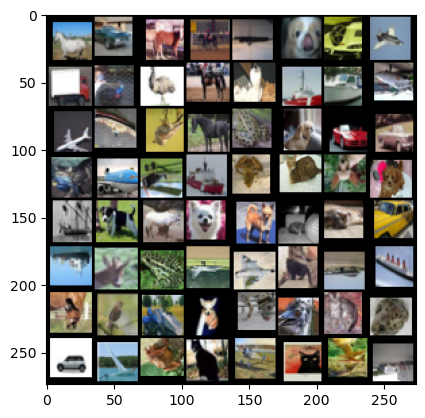

In [4]:
def random_grid(imgs, sz: int):
    grid = tu.make_grid(imgs)
    return grid.permute(1, 2, 0)

num=64
augmented = torch.stack([x[0] for x in random.choices(cifar_train, k=num)])
print(augmented.shape, augmented.mean())
tmps = random_grid(augmented, num)
plt.imshow(tmps.cpu())

# Transformer Block

In [5]:
class SDPA(nn.Module):
    def __init__(self, positions, dkv):
        super().__init__()
        self.pos = positions
        self.d = dkv
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, q, k, v):
        assert(self.d == k.shape[-1])
        q_dot_k = torch.bmm(q, (k.transpose(-2, -1)))
        scaled = q_dot_k / (math.sqrt(self.d))
        logits = self.softmax(scaled)
        out = torch.bmm(logits, v)
        return out

class Head(nn.Module):
    def __init__(self, positions, dkv, dmodel):
        super().__init__()
        self.v_projection = nn.Linear(dmodel, dkv)
        self.k_projection = nn.Linear(dmodel, dkv)
        self.q_projection = nn.Linear(dmodel, dkv)

        self.sdpa = SDPA(positions, dkv)

    def forward(self, v, k, q):
        vp = self.v_projection(v)
        kp = self.k_projection(k)
        qp = self.q_projection(q)
        return self.sdpa(qp, kp, vp)

class MHA(nn.Module):
    def __init__(self, positions, nhead, dmodel):
        super().__init__()
        assert(dmodel % nhead == 0)
        self.heads = nn.ModuleList([Head(positions, dmodel//nhead, dmodel) for _ in range(nhead)])

        # TODO In the paper it's called WO, and hd_v x dmodel, but b/c d_v = dmodel/h it turns out to be square.
        self.out_projection = nn.Linear(dmodel, dmodel)

    def forward(self, v, k, q):
        head_outputs = [h(v, k, q) for h in self.heads]
        catd = torch.cat(head_outputs, dim=-1)

        projection = self.out_projection(catd)
        return projection

class FeedForward(nn.Module):
    def __init__(self, dmodel, ff, dropout=0.1):
        super().__init__()
        self.f0 = nn.Linear(dmodel, ff)
        self.f1 = nn.Linear(ff, dmodel)
        self.dropout = nn.Dropout(p=dropout)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.f0(x)
        x = self.act(x)
        x = self.f1(x)
        x = self.dropout(x)
        return x

# Input/Output are Batch, Positions, then Model Dimension.
class TransformerBlock(nn.Module):
    def __init__(self, positions, dmodel, ff, nhead, dropout=0.1):
        super().__init__()
        self.mha = MHA(positions, nhead, dmodel)
        self.layernorm0 = nn.LayerNorm(dmodel)
        self.feedforward = FeedForward(dmodel, ff, dropout)
        self.layernorm1 = nn.LayerNorm(dmodel)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, inputs):
        x = self.mha(inputs, inputs, inputs)
        x = self.layernorm0(x + inputs)

        x_pre_ff = x
        x = self.feedforward(x)
        x = self.layernorm1(x + x_pre_ff)
        return x

class Transformer(nn.Module):
    def __init__(self, positions, dmodel, ff, nhead, nlayers, dropout=0.1):
        super().__init__()
        self.transformer_layers = nn.ModuleList([TransformerBlock(positions, dmodel, ff, nhead=nhead, dropout=dropout) for _ in range(nlayers)])

    def forward(self, x):
        for layer in self.transformer_layers:
            x = layer(x)
        return x

# ViT Specific layers

In [6]:
# Input B C H W
class Tokenizer(nn.Module):
    def __init__(self, c_in, emb_len, patch_dim):
        super().__init__()
        self.conv0 = nn.Conv2d(c_in, emb_len, patch_dim, stride=patch_dim)

    def forward(self, x):
        x = self.conv0(x)
        x = x.flatten(2)
        x = x.permute(0, 2, 1)
        return x

# Input B, (P * P), C
class Embeddings(nn.Module):
    def __init__(self, emb_len, patch_num, dropout=0.1):
        super().__init__()
        # nn.Parameter is used so that PyTorch knows this is part of the network.
        # Specifically it makes this value appear whenever model.parameters() is called.
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_len))
        self.pos_emb = nn.Parameter(
            torch.randn(1, patch_num + 1, emb_len)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        b, p2, c = x.shape

        cls_tok = self.cls_token.expand(b, -1, -1)
        x = torch.cat((cls_tok, x), dim=1)
        x = x + self.pos_emb
        x = self.dropout(x)
        return x

class ClassHead(nn.Module):
    def __init__(self, emb_len, patch_num, hidden_sz, classes, dropout=0.1):
        super().__init__()
        self.fc0 = nn.Linear(emb_len, hidden_sz)
        self.activation = nn.ReLU()
        self.fc1 = nn.Linear(hidden_sz, classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # We're slicing out the CLS token slot here. This is the only slot that matters.
        x = inp[:, 0, :]
        x = self.fc0(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc1(x)

        return x

class VIT(nn.Module):
    def __init__(self, num_classes, patchsz, emb_dim, layers=4, heads=4, dim_ff=64, load=None):
        super().__init__()
        self.tokenizer = Tokenizer(3, emb_dim, patchsz)
        self.embeddings = Embeddings(emb_dim, patch_num, 0.1) # 64 = (32 / 4)**2
        self.transformer = Transformer(patch_num + 1, emb_dim, dim_ff, heads, layers, dropout=0.1)
        self.class_head = ClassHead(emb_dim, patch_num + 1, 2*emb_dim, num_classes)
        if load and os.path.isfile(load):
            print(f"Will load weights from {load}")
            self.load_state_dict(torch.load(load))

    def forward(self, x):
        x = self.tokenizer(x)
        x = self.embeddings(x)
        x = self.transformer(x)
        x = self.class_head(x)
        return x

    def save(self, name='vit_classification.pth'):
        torch.save(self.state_dict(), name)

# Training Loop

Layer (type:depth-idx)                                  Output Shape              Param #
VIT                                                     [1, 10]                   --
├─Tokenizer: 1-1                                        [1, 64, 128]              --
│    └─Conv2d: 2-1                                      [1, 128, 8, 8]            6,272
├─Embeddings: 1-2                                       [1, 65, 128]              8,448
│    └─Dropout: 2-2                                     [1, 65, 128]              --
├─Transformer: 1-3                                      [1, 65, 128]              --
│    └─ModuleList: 2-3                                  --                        --
│    │    └─TransformerBlock: 3-1                       [1, 65, 128]              198,272
│    │    └─TransformerBlock: 3-2                       [1, 65, 128]              198,272
│    │    └─TransformerBlock: 3-3                       [1, 65, 128]              198,272
│    │    └─TransformerBlock: 3-4      

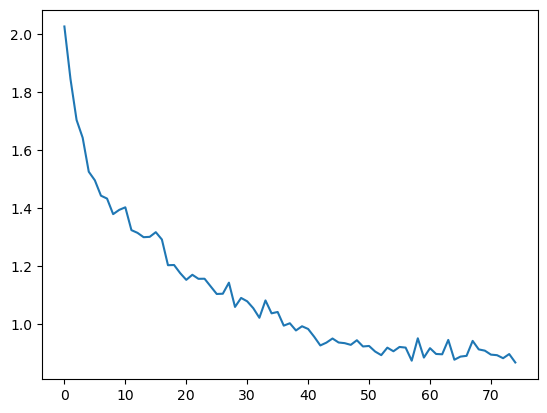

In [7]:
%%time

imgsz = 32  # Images are this many pixels tall and wide in CIFAR10
patchsz = 4 # Patchsize of 4 results in 8x8 patches,
emb_dim = 128  # AKA dmodel. Try reduce this if it takes too long to train.
patch_num = (imgsz // patchsz)**2
vit = VIT(
    10,
    patchsz,
    emb_dim,
    layers=4,
    heads=4,
    dim_ff=4*128,
    load='vit_classification.pth'  # Set to the saved model path to start from a checkpoint.
).to(device)

# !pip install torchinfo
try:
    from torchinfo import summary; print(summary(vit, (1, 3, 32, 32), device=device))
except ImportError:
    print("torchinfo isn't installed. Try `pip install torchinfo` to see a summary of the model shapes and param counts")

# Anecdotally the model stops improving at around 72%, 75 epochs is usually enough to get there.
epochs = 75
optimizer = torch.optim.AdamW(vit.parameters(), lr=1e-3, weight_decay=1e-2)

lossfn = nn.CrossEntropyLoss()

loss_plot = []
for epoch in range(epochs):
    vit.train()
    for i, (images, target) in enumerate(train_loader):
        optimizer.zero_grad()
        images = images.float().to(device)
        targets = target.to(device)

        outs = vit(images)

        # If you're wondering why there's no (Log)SoftMax here or in the network, it's because
        # PyTorch does it for you inside the CrossEntropyLoss operation.
        loss = lossfn(outs, targets)
        loss.backward()
        optimizer.step()

    losses = []
    vit.eval() # Certain layers like dropout behave differently during evaluation vs training.
    correct = 0
    total = len(cifar_eval)
    for i, (images, target) in enumerate(val_loader):
        with torch.no_grad():
            images = images.float().to(device)
            targets = target.to(device)
            outs  = vit(images)
            loss = lossfn(outs, targets)
            losses.append(loss)
            for x in range(outs.shape[0]):
                preds = F.softmax(outs, dim=1)
                cls = preds[x].argmax()
                lbl = targets[x]
                if cls == lbl:
                    correct += 1

    epoch_loss = torch.Tensor(losses).mean().item()
    print("Epoch {}, Current loss is {}".format(epoch, epoch_loss))
    print("{}/{} correct, {:.2f}%".format(correct, total, 100*correct/total))
    loss_plot.append(epoch_loss)

plt.plot(loss_plot)

# Evaluation with Confusion Matrix

Here are your CIFAR10 classes for reference
```
0:"Airplane"
1:"Automobile"
2:"Bird"
3:"Cat"
4:"Deer"
5:"Dog"
6:"Frog"
7:"Horse"
8:"Ship"
9:"Truck"
```
Your confusion matrix will likely show error between 3 and 5, cats and dogs, which seems reasonable.

100%|████████████████████████████████████| 10000/10000 [00:28<00:00, 353.07it/s]


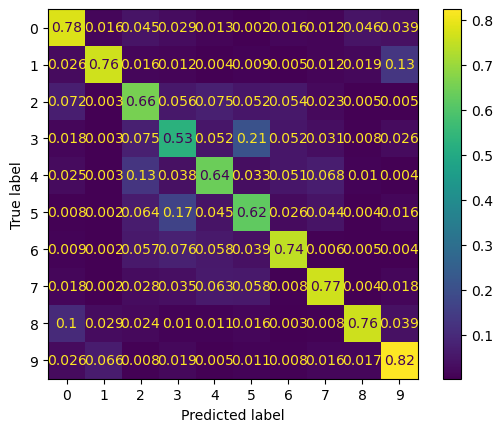

In [8]:
# !pip install scikit-learn
from sklearn import metrics

evals = cifar_eval
right = 0; total = 0; y_pred=[]; y_true=[]

vit.eval()
with torch.no_grad():
    for image, target in tqdm(cifar_eval):
        pred  = vit(image.unsqueeze(0).float().to(device))
        pred = F.softmax(pred, dim=1).argmax()

        y_pred.append(pred.item())
        y_true.append(target)

metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred, normalize='true')

# Deep Similarity
ViT can also be adapted for similarity search. When trained on a classification task, the output state of the [CLS] token will tend to be similar for objects in the same class.
You can see that by rerunning the cell below a few times. On each pass, two images are randomly selected and the last hidden state before the classification head is saved.

Broadly, the similarity should be high for objects within the same class. It would also make sense for objects that show signifcant overlap on the confusion matrix to also have similar embeddings.

However since this model is not trained to produce any particular embeddings, don't expect too much.

In [9]:
ix_to_lbl = {
    0:"Airplane",
    1:"Automobile",
    2:"Bird",
    3:"Cat",
    4:"Deer",
    5:"Dog",
    6:"Frog",
    7:"Horse",
    8:"Ship",
    9:"Truck"
}

In [10]:
hidden_state = []
def hook(model, input, output):
    hidden_state.append(output[0, 0, :].detach())
    
# Using a forward hook lets you grab the output of a specific layer without
# changing model code.
vit.transformer.register_forward_hook(hook)

Targets are Bird and Dog, similarity 0.21690575778484344


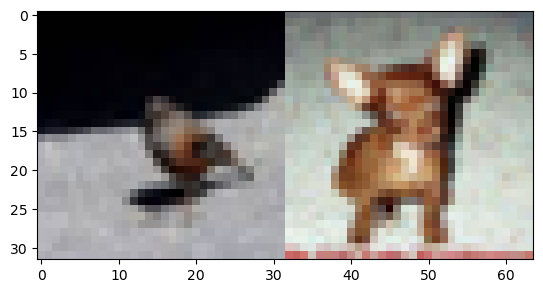

In [11]:
vit.eval()
sz = len(cifar_eval)
import random

hidden_state = []
sim_metric = nn.CosineSimilarity(dim=0, eps=1e-6)
with torch.no_grad():
    i0, t0 = cifar_eval[random.randint(0, sz)]
    i1, t1 = cifar_eval[random.randint(1, sz)]
    t0 = ix_to_lbl[t0]; t1 = ix_to_lbl[t1]
    
    pred0 = vit(i0.unsqueeze(0).float().to(device))
    pred1 = vit(i1.unsqueeze(0).float().to(device))

    sim = sim_metric(hidden_state[0], hidden_state[1])
    print(f"Targets are {t0} and {t1}, similarity {sim}")
    ims = torch.cat((i0, i1), dim=2).squeeze().permute(1, 2, 0)
    plt.imshow(ims.cpu().numpy())

Let's test our embeddings by embedding the entire eval dataset and finding the best matches.

In [12]:
# Embed every image in the eval set. Because of the hook we set up earlier, they'll all end up in the hidden_state list
hidden_state = []
for image, target in tqdm(cifar_eval):
    _ = vit(image.unsqueeze(0).float().to(device))

100%|████████████████████████████████████| 10000/10000 [00:34<00:00, 289.78it/s]


Using our embeddings, let's find the top 8 best matches with cosine similarity and plot them!

The query image will be a perfect match with itself, and therefore be the first image on the left.

Results:  [('Cat', 1.0), ('Cat', 0.6555997133255005), ('Cat', 0.6381435394287109), ('Truck', 0.6234979629516602), ('Horse', 0.6156017780303955), ('Dog', 0.6154485940933228), ('Cat', 0.612826943397522), ('Horse', 0.6110649108886719)]


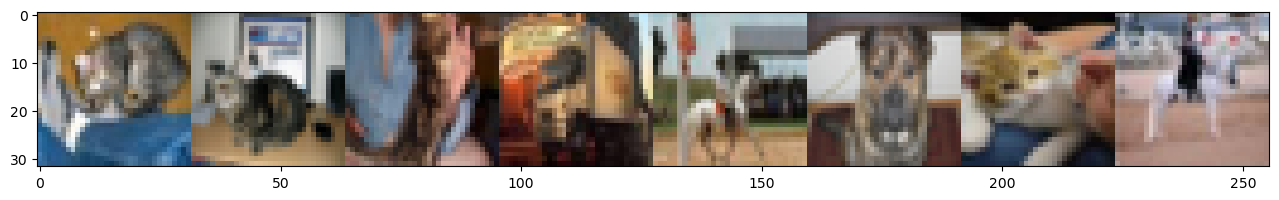

In [13]:
embs = torch.stack(hidden_state)

# This is the image we're using as our point of comparison.
# We're computing similarity of this image, vs eveyryone else!
sample_ix = 0

sample = embs[sample_ix]
sim_metric = nn.CosineSimilarity(dim=1, eps=1e-6)
sims = sim_metric(sample, embs)
vals, indicies = torch.topk(sims, 8)

ims = [cifar_eval[x][0] for x in indicies]
cls = [cifar_eval[x][1] for x in indicies]

ims = torch.cat(ims, dim=2).squeeze().permute(1, 2, 0)

fig, ax = plt.subplots(figsize=(16, 2))
ax.imshow(ims.cpu().numpy())

# Print the class and cosine similarity score for the 8 (well, 7) best matches.
print("Results: ", list(zip([ix_to_lbl[x] for x in cls], [x.item() for x in vals.cpu()])))

In [14]:
# Uncomment to save your weights.
# If you come back to this notebook, the ViT model class will load your weights when it is initialized if it finds 'vit_classification.pth'
# vit.save()

# Some ideas for improving classification performance
* Increase model dimensions. More attention heads, more sequential transformers, bigger feedforward, different patch sizes.
* Add augmentations to the dataset transform functions. `RandomResizedCrop` would be a good choice.
* Normalize the images to mean=0 std=1. Right now they're just scaled to be between 0 and 1.
* Introduce a learning rate schedule to cool the learning rate as training progresses.